# Neural Network using NumPy

In [1]:
import numpy as np

## Load and preprocess dataset

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.utils import shuffle

DATA_ROOT_DIR = "."
IMG_WIDTH, IMG_HEIGHT = 28, 28

def load_rgb_images_from_subdir(subdir_path, target_img_width=None, target_img_height=None):
    X_data_list, y_data_list = [], []
    class_names = sorted([d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))])
    label_map = {class_name: i for i, class_name in enumerate(class_names)}
    for class_name, label in label_map.items():
        class_dir = os.path.join(subdir_path, class_name)
        for image_file in os.listdir(class_dir):
            try:
                img = Image.open(os.path.join(class_dir, image_file)).convert('RGB')
                if target_img_width and target_img_height:
                    img = img.resize((target_img_width, target_img_height), Image.Resampling.LANCZOS)
                X_data_list.append(np.array(img).flatten())
                y_data_list.append(label)
            except:
                continue
    return np.array(X_data_list, dtype=np.uint8), np.array(y_data_list, dtype=np.int64)

train_dir = os.path.join(DATA_ROOT_DIR, "augmented_train-2")
test_dir = os.path.join(DATA_ROOT_DIR, "test-2")

X_train_uint8, y_train = load_rgb_images_from_subdir(train_dir, IMG_WIDTH, IMG_HEIGHT)
X_test_uint8, y_test = load_rgb_images_from_subdir(test_dir, IMG_WIDTH, IMG_HEIGHT)

X_train = (X_train_uint8.astype(np.float32) / 127.5) - 1.0
X_test = (X_test_uint8.astype(np.float32) / 127.5) - 1.0

X_train, y_train = shuffle(X_train, y_train, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 2352) (60000,)
(2000, 2352) (2000,)


## Batch generator

In [3]:
def get_batches(X, y, batch_size):
    # Shuffle data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Yield batches
    for i in range(0, X.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
        yield X_batch, y_batch

## Layer: Dense

In [4]:
class Layer_Dense:
    def __init__(self,n_inputs,n_neurons,weight_regularizer_l1=0,weight_regularizer_l2=0,bias_regularizer_l1=0,bias_regularizer_l2=0):
        self.weights=0.01*np.random.randn(n_inputs,n_neurons)
        self.biases=np.zeros((1,n_neurons))
        self.weight_regularizer_l1=weight_regularizer_l1
        self.weight_regularizer_l2=weight_regularizer_l2
        self.bias_regularizer_l1=bias_regularizer_l1
        self.bias_regularizer_l2=bias_regularizer_l2
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.dot(inputs,self.weights)+self.biases
    def backward(self,dvalues):
        self.dweights=np.dot(self.inputs.T,dvalues)
        self.dbiases=np.sum(dvalues,axis=0,keepdims=True)
        #regularization
        if self.weight_regularizer_l1>0:
            dL1=np.ones_like(self.weights)
            dL1[self.weights<1]=-1
            self.dweights+=self.weight_regularizer_l1*dL1
        if self.weight_regularizer_l2>0:
            self.dweights+=2*self.weight_regularizer_l2*self.weights
        if self.bias_regularizer_l1>0:
            dL1=np.ones_like(self.biases)
            dL1[self.biases<1]=-1
            self.dbiases+=self.bias_regularizer_l1*dL1
        if self.bias_regularizer_l2>0:
            self.dbiases+=2*self.bias_regularizer_l2*self.biases
        self.dinputs=np.dot(dvalues,self.weights.T)

## Layer: Activation_ReLU:

In [5]:
class Activation_ReLU:
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.maximum(0,inputs)
    def backward(self,dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs<=0]=0

## Layer: Activation_Softmax:

In [6]:
class Activation_Softmax:
    def forward(self,inputs):
        self.inputs=inputs
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True))
        probabilities=exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.output=probabilities
    def backward(self,dvalues):
        self.dinputs=np.empty_like(dvalues)
        for index,(single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_output=single_output.reshape(-1,1)
            jacobian_matrix=np.diagflat(single_output)-np.dot(single_output,single_output.T)
            self.dinputs[index]=np.dot(jacobian_matrix,single_dvalues)

## Layer: Loss:

In [7]:
class Loss:
    def regularization_loss(self,layer):
        regularization_loss=0
        if layer.weight_regularizer_l1>0:
            regularization_loss+=layer.weight_regularizer_l1*np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2>0:
            regularization_loss+=layer.weight_regularizer_l2*np.sum(layer.weights*layer.weights)
        if layer.bias_regularizer_l1>0:
            regularization_loss+=layer.bias_regularizer_l1*np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2>0:
            regularization_loss+=layer.bias_regularizer_l2*np.sum(layer.biases*layer.biases)
        return regularization_loss
    
    def calculate(self,output,y):
        sample_losses=self.forward(output,y)
        data_loss=np.mean(sample_losses)
        return data_loss

## Layer: Loss_CategoricalCrossentropy

In [8]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples=len(y_pred)
        y_pred_clipped=np.clip(y_pred,1e-7,1-1e-7)
        if len(y_true.shape)==1:
            corrected_confidences=y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape)==2:
            corrected_confidences=np.sum(y_pred_clipped*y_true,axis=1)
        negative_log_likelihoods=-np.log(corrected_confidences)
        return negative_log_likelihoods
    def backward(self,dvalues,y_true):
        samples=len(dvalues)
        labels=len(dvalues[0])
        if len(y_true.shape)==1:
            y_true=np.eye(labels)[y_true]
        self.dinputs=-y_true/dvalues
        self.dinputs=self.dinputs/samples

## Layer: Activation_Softmax_Loss_CategoricalCrossentropy

In [9]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation=Activation_Softmax()
        self.loss=Loss_CategoricalCrossentropy()
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output=self.activation.output
        return self.loss.calculate(self.output,y_true)
    def backward(self,dvalues,y_true):
        samples=len(dvalues)
        if len(y_true.shape)==2:
            y_true=np.argmax(y_true,axis=1)
        self.dinputs=dvalues.copy()
        self.dinputs[range(samples),y_true]-=1
        self.dinputs=self.dinputs/samples

## Layer: Optimizer_Adam:

In [10]:
class Optimizer_Adam:
    def __init__(self,learning_rate=0.0005,decay=0.,epsilon=1e-7,beta_1=0.9,beta_2=0.999):
        self.learning_rate=learning_rate
        self.current_learning_rate=learning_rate
        self.decay=decay
        self.iterations=0
        self.epsilon=epsilon
        self.beta_1=beta_1
        self.beta_2=beta_2
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate=self.learning_rate*(1/(1+self.decay*self.iterations))
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_momentums=np.zeros_like(layer.weights)
            layer.weight_cache=np.zeros_like(layer.weights)
            layer.bias_momentums=np.zeros_like(layer.biases)
            layer.bias_cache=np.zeros_like(layer.biases)


        layer.weight_momentums=self.beta_1*layer.weight_momentums+(1-self.beta_1)*layer.dweights
        layer.bias_momentums=self.beta_1*layer.bias_momentums+(1-self.beta_1)*layer.dbiases

        weight_momentums_corrected=layer.weight_momentums/(1-self.beta_1**(self.iterations+1))
        bias_momentums_corrected=layer.bias_momentums/(1-self.beta_1**(self.iterations+1))

        layer.weight_cache=self.beta_2*layer.weight_cache+(1-self.beta_2)*layer.dweights**2
        layer.bias_cache=self.beta_2*layer.bias_cache+(1-self.beta_2)*layer.dbiases**2

        weight_cache_corrected=layer.weight_cache/(1-self.beta_2**(self.iterations+1))
        bias_cache_corrected=layer.bias_cache/(1-self.beta_2**(self.iterations+1) )

        layer.weights+=-self.current_learning_rate*weight_momentums_corrected/(np.sqrt(weight_cache_corrected)+self.epsilon)
        layer.biases+=-self.current_learning_rate*bias_momentums_corrected/(np.sqrt(bias_cache_corrected)+self.epsilon)
    def post_update_params(self):
        self.iterations+=1

## Layer: Layer_Droput:

In [11]:
class Layer_Droput:
    def __init__(self,rate):
        self.rate=1-rate
    def forward(self,inputs):
        self.inputs=inputs
        self.binary_mask=np.random.binomial(1,self.rate,size=inputs.shape)/self.rate
        self.output=inputs*self.binary_mask
    def backward(self,dvalues):
        self.dinputs=dvalues*self.binary_mask

## Layer Declaration

In [12]:
dense1=Layer_Dense(2352,2048,weight_regularizer_l2=5e-4,bias_regularizer_l2=5e-4)
activation1=Activation_ReLU()
dropout1=Layer_Droput(0.1)
dense2=Layer_Dense(2048,512)
activation2=Activation_ReLU()
dropout2=Layer_Droput(0.1)
dense3=Layer_Dense(512,10)
loss_activation=Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer=Optimizer_Adam(learning_rate=1e-4,decay=5e-5)
train_losses=[]
val_losses=[]
train_acc=[]
val_acc=[]

## Training

In [13]:

for epoch in range(30):
    for X_batch, y_batch in get_batches(X_train, y_train, 32):
        dense1.forward(X_batch)
        activation1.forward(dense1.output)
        dropout1.forward(activation1.output)
        dense2.forward(dropout1.output)
        activation2.forward(dense2.output)
        dropout2.forward(activation2.output)
        dense3.forward(dropout2.output)
        data_loss=loss_activation.forward(dense3.output,y_batch)
        regularization_loss=loss_activation.loss.regularization_loss(dense1)+loss_activation.loss.regularization_loss(dense2)+loss_activation.loss.regularization_loss(dense3)
        loss=data_loss+regularization_loss

        predictions=np.argmax(loss_activation.output,axis=1)
        if len(y_batch.shape)==2:
            y_batch=np.argmax(y_batch,axis=1)
        accuracy=np.mean(predictions==y_batch)
        #backward pass
        loss_activation.backward(loss_activation.output,y_batch)
        dense3.backward(loss_activation.dinputs)
        dropout2.backward(dense3.dinputs)
        activation2.backward(dropout2.dinputs)
        dense2.backward(activation2.dinputs)
        dropout1.backward(dense2.dinputs)
        activation1.backward(dropout1.dinputs)
        dense1.backward(activation1.dinputs)

        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.post_update_params()
    #testing 
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    activation2.forward(dense2.output)
    dropout2.forward(activation2.output)
    dense3.forward(dropout2.output)
    loss_val=loss_activation.forward(dense3.output,y_test)

    predictions=np.argmax(loss_activation.output,axis=1)
    if len(y_test.shape)==2:
        y_test=np.argmax(y_test,axis=1)
    accuracy_val=np.mean(predictions==y_test)
    if (epoch+1)%1==0:
        print(f'epoch:{epoch+1},acc:{accuracy:.3f},loss:{loss:.3f},val_acc:{accuracy_val}')
    #data_loss:{data_loss},reg_loss:{regularization_loss},lr:{optimizer.current_learning_rate}
    train_losses.append(loss)
    val_losses.append(loss_val)
    train_acc.append(accuracy)
    val_acc.append(accuracy_val)
    

epoch:1,acc:0.281,loss:1.989,val_acc:0.416
epoch:2,acc:0.344,loss:1.722,val_acc:0.4875
epoch:3,acc:0.406,loss:1.863,val_acc:0.5155
epoch:4,acc:0.406,loss:1.959,val_acc:0.5375
epoch:5,acc:0.562,loss:1.420,val_acc:0.5635
epoch:6,acc:0.594,loss:1.405,val_acc:0.571
epoch:7,acc:0.625,loss:1.264,val_acc:0.5835
epoch:8,acc:0.688,loss:1.303,val_acc:0.5795
epoch:9,acc:0.719,loss:1.129,val_acc:0.5835
epoch:10,acc:0.719,loss:1.026,val_acc:0.5875
epoch:11,acc:0.906,loss:0.640,val_acc:0.589
epoch:12,acc:0.531,loss:1.267,val_acc:0.599
epoch:13,acc:0.844,loss:0.623,val_acc:0.6065
epoch:14,acc:0.875,loss:0.585,val_acc:0.595
epoch:15,acc:0.812,loss:0.867,val_acc:0.588
epoch:16,acc:0.781,loss:0.869,val_acc:0.608
epoch:17,acc:0.875,loss:0.843,val_acc:0.6035
epoch:18,acc:0.938,loss:0.442,val_acc:0.5865
epoch:19,acc:0.875,loss:0.649,val_acc:0.587
epoch:20,acc:0.906,loss:0.478,val_acc:0.595
epoch:21,acc:0.875,loss:0.619,val_acc:0.602
epoch:22,acc:0.906,loss:0.618,val_acc:0.5985
epoch:23,acc:1.000,loss:0.342

## Plot Training and Validation Loss

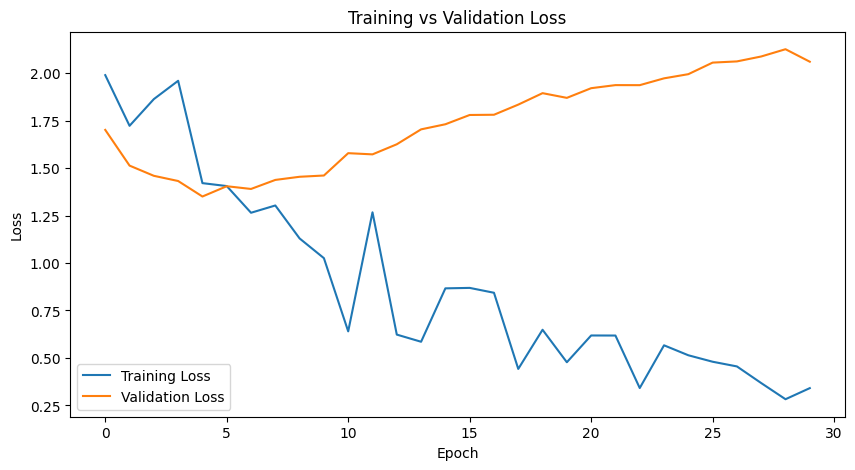

In [14]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


## Plot Training and Validation Accuracy

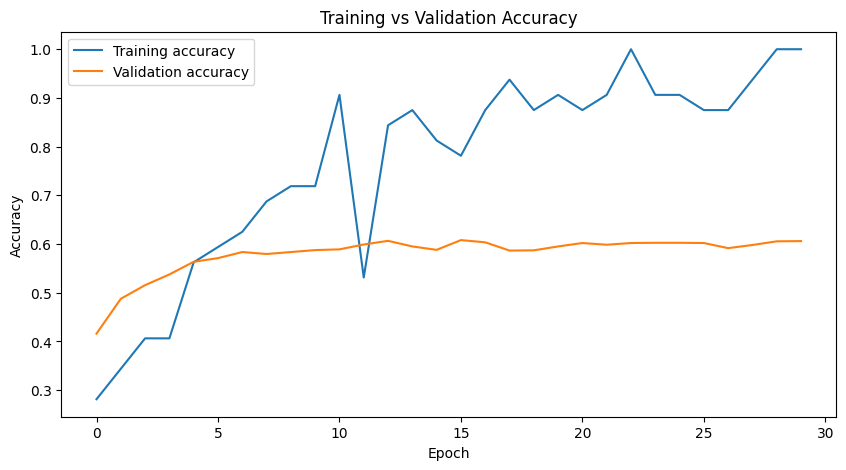

In [15]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Training accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [16]:
print(f'Accuracy: {accuracy_val * 100:.2f}%')

Accuracy: 60.60%
